In [1]:
# install and import library
!pip install -i https://test.pypi.org/simple/ FiniteDiff==0.0.2
from FiniteDiff import FD

# just used for interactive visual, not required for anything else
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

Diffusion

Finite approximation: f' = [-f(x-0.5h) + f(x+0.5h)] / [h^1]

Finite approximation: f' = [-f(x-0.5h) + f(x+0.5h)] / [h^1]

Boundary conditions and initial conditions may be in conflict for field Temperature
Conflicting values override and become equal to whatever was assigned last

CFL: 0.25, must be under 0.5 for stability

All initial conditions set!



interactive(children=(Dropdown(description='Field', options=('Temperature', 'Temperature dot', 'Temperature Fl…

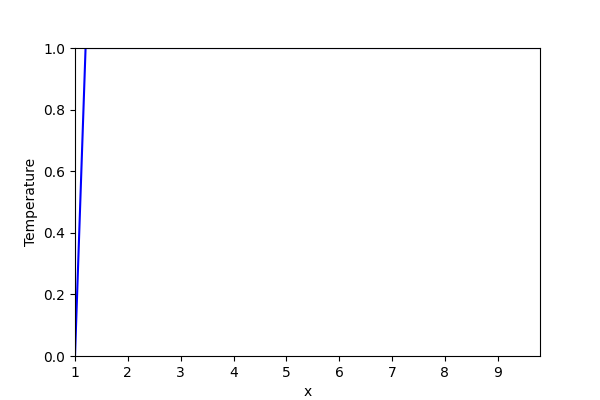

In [4]:
%matplotlib widget
import FD
import numpy as np

# model parameters:
dx = 0.2
dt = 0.01
k = 1

# Create a single Model object for the domain, with a time dimension and space dimension(s).

m = FD.Model(
    {"x": np.arange(1,10,dx), 
     "t": np.arange(1,30,dt)},
    time_axis = "t")


# Create fields representing a property that changes over time as a scalar field. 
# For this example, temperature would be at the cells, while temperature flux would be at the edges between the cells.

Tflux = FD.Field(m, "Temperature Flux", n_time_ders = 0, edge_axes = "x")
T = FD.Field(m, "Temperature", n_time_ders = 1)


# Create stencils for numerical approximations of spatial derivatives.

cell_to_edge = FD.Stencil([-1/2,1/2],der_order=1,axis_type="cell",der_axis_type="edge")
edge_to_cell = FD.Stencil([-1/2,1/2],der_order=1,axis_type="edge",der_axis_type="cell")

# Boundary conditions and initial conditions are applied. 
# In this case, the temperature is fixed on one end and the flux is fixed on the other.

T.set_IC("1")
T.set_BC("0","x","start")
Tflux.set_BC("0","x","end")

# Optionally, check stability. Note that this simple criteria is only valid for this specific example.
CFL = k*dt/dx**2
print(f"CFL: {round(CFL,3)}, must be under 0.5 for stability\n")


m.check_IC() # not required, but recommended: checks if all necessary initial conditions have been set up

# Run the simulation in a loop, updating the fields each iteration

while not m.finished:

    # Tflux = k*dT/dx:
    dTdx = cell_to_edge.der(T.prev,"x") 
    Tflux.assign_update(k * dTdx)

    # dT/dt = dTflux/dx:
    Tp = edge_to_cell.der(Tflux.new,"x")
    T.dot.assign_update(Tp)

    # T = int(dT/dt) dt:
    T.time_integrate_update()

    # increment time:
    m.increment_time()

# get numpy arrays of the temperature and temperature flux:
Tflux.data
T.data   

# create an interactive visual in the jupyter notebook:
m.interact() 



Advection

Finite approximation: f' = [-0.5f(x-h) + 0f(x+0h) + 0.5f(x+h)] / [h^1]

All initial conditions set!



interactive(children=(Dropdown(description='Field', options=('Concentration', 'Concentration dot'), value='Con…

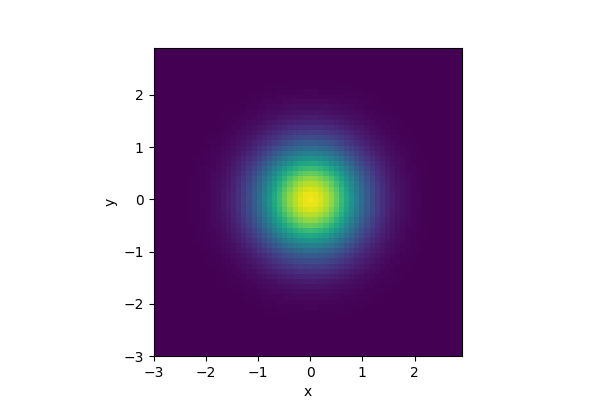

In [11]:
import FD
import numpy as np

# Speed of flow in the x and y directions:
u = 1
v = 0.5

# In this case, the domain is periodic in both directions:
m = FD.Model(
    {"x": np.arange(-3,3,0.1),
    "y": np.arange(-3,3,0.1),
    "t": np.linspace(0,4,1000)},
    time_axis="t",
    periodic=("x","y"))

# Construct a field for some generic substance concentration 
# (could be whatever you want it to be)
f = FD.Field(m,"Concentration",n_time_ders=1)

# A central difference scheme will be used:
cen_diff = FD.Stencil([-1,0,1],1)

# No need for setting periodic boundary conditions since it's periodic
f.set_IC("exp(-x**2-y**2)")

# Again, good practice:
m.check_IC()

# And iterate as before:
while not m.finished:

    # df/dt = u*dfdx+v*dfdy
    dfdx = cen_diff.der(f.prev,"x")
    dfdy = cen_diff.der(f.prev,"y")
    dfdt = u*dfdx+v*dfdy
    f.dot.assign_update(dfdt)

    # f = int(dfdt)dt
    f.time_integrate_update()

    # increment time
    m.increment_time()

m.interact()



Refraction

In [ ]:
from FD import *
import numpy as np

# gravity:
g = 9.8

# create model:
m = Model(
    {"x":np.linspace(0,10,100),
     "y":np.linspace(0,10,100),
     "t":np.arange(0,4,0.01)},
     time_axis="t"
)

# set up fields:
u = Field(m,"u",edge_axes="x",n_time_ders=1)
v = Field(m,"v",edge_axes="y",n_time_ders=1)
eta = Field(m,"eta",n_time_ders=1)

# create a constant field for the unchanging bathyemtry
# (for now, two fields are required, with the edges on different axes
# in the future, I want to make this unnecessary...)
h_for_u = ConstantField(m,"bath",edge_axes="x")
h_for_v = ConstantField(m,"bath",edge_axes="y")
bath = "(25-x-y)/20" # bathymetry is sloped in both directions
h_for_u.set(bath)
h_for_v.set(bath)

# set the BCs, the left side of the domain has a wavemaker
u.set_BC("sin(t*10)","x","start") # wavemaker
u.set_BC("0","x","end")
v.set_BC("0","y","start")
v.set_BC("0","y","end")

# still water initial conditions:
eta.set_IC("0")
u.set_IC("0")
v.set_IC("0")

# same stencils used for diffusion problem, first order for both:
c_e = Stencil([-1/2,1/2],1,axis_type="cell",der_axis_type="edge")
e_c = Stencil([-1/2,1/2],1,axis_type="edge",der_axis_type="cell")

# again, good to check
m.check_IC()

# iterate
while not m.finished:

    # dudt = g*deta/dx
    # dvdt = g*deta/dy
    detadx = c_e.der(eta.prev,"x")
    detady = c_e.der(eta.prev,"y")
    u.dot.assign_update(g*detadx)
    v.dot.assign_update(g*detady)

    # u = int(dudt)dt
    # v = int(dvdt)dt
    u.time_integrate_update()
    v.time_integrate_update()

    # detadt = d(h*u)dx + d(h*v)dy
    dhudx = e_c.der(h_for_u.always * u.new,"x")
    dhvdy = e_c.der(h_for_v.always * v.new,"y")
    eta.dot.assign_update(dhudx + dhvdy)

    # eta = int(detadt)dt
    eta.time_integrate_update()

    # increment time
    m.increment_time()

m.interact()


